In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime



# Colors

In [4]:
import rasterio
import numpy as np

# Load TEMP
ndvi = rasterio.open('Temperature_Kochi.tif').read(1)

# Load veg 
lst = rasterio.open('Vegetation_Kochi.tif').read(1)

# statisics of kochi 
stk=pd.read_csv('Statistics_Kochi.csv')

# load aod 
aod= pd.read_csv('AOD_Statistics_Kochi.csv')


In [12]:
aod_df.head()


,system:index,avg_AOD,date_from,date_to,region,.geo
0,0,420.988098,2025-09-04,2025-10-04,Kochi,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [19]:
import rasterio
import numpy as np
import pandas as pd
from rasterio.warp import reproject, Resampling

# --- Function to normalize arrays (0–1), ignoring NaN ---
def normalize(arr):
    arr = arr.astype('float32')
    arr[arr == -9999] = np.nan   # handle fill values if present
    if np.nanmin(arr) == np.nanmax(arr):
        return np.zeros_like(arr)  # avoid division by zero
    return (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr))

# --- Function to reproject / resample a raster to match reference ---
def match_raster(src_array, src_transform, src_crs, target_meta):
    dst_array = np.empty((target_meta['height'], target_meta['width']), dtype='float32')
    reproject(
        source=src_array,
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_array

# --- Load reference raster (Temperature) ---
with rasterio.open("Temperature_Kochi.tif") as src:
    temp = src.read(1)
    temp_meta = src.meta.copy()
    transform = src.transform  # for x,y coordinates

# --- Load and resample NDVI to match Temperature ---
with rasterio.open("Vegetation_Kochi.tif") as src:
    ndvi = match_raster(src.read(1), src.transform, src.crs, temp_meta)

# --- Load and resample AOD to match Temperature ---
with rasterio.open("AOD_Kochi_30day.tif") as src:
    aod = match_raster(src.read(1), src.transform, src.crs, temp_meta)

# --- Normalize ---
temp_norm = normalize(temp)
ndvi_norm = normalize(ndvi)
aod_norm  = normalize(aod)

# --- Comfort score ---
comfort = (ndvi_norm * 0.5) + ((1 - temp_norm) * 0.3) + ((1 - aod_norm) * 0.2)

# --- Save as GeoTIFF ---
out_meta = temp_meta.copy()
out_meta.update({"dtype": "float32", "count": 1})
with rasterio.open("Comfort_Index_Kochi.tif", "w", **out_meta) as dest:
    dest.write(comfort.astype("float32"), 1)

print("✅ Comfort Index saved as Comfort_Index_Kochi.tif")

# --- Convert raster to CSV (x, y, comfort_value) ---
rows, cols = np.where(~np.isnan(comfort))  # valid pixels only
xs, ys = rasterio.transform.xy(transform, rows, cols)
data = {
    "x": xs,
    "y": ys,
    "comfort": comfort[rows, cols]
}

df = pd.DataFrame(data)
df.to_csv("Comfort_Index_Kochi.csv", index=False)

print("✅ Comfort Index also saved as Comfort_Index_Kochi.csv")


✅ Comfort Index saved as Comfort_Index_Kochi.tif
✅ Comfort Index also saved as Comfort_Index_Kochi.csv


In [20]:
df =pd.read_csv('Comfort_Index_Kochi.csv')

In [21]:
df.head()

,x,y,comfort
0,76.271459,10.038673,0.636016
1,76.280442,10.038673,0.663818
2,76.289426,10.038673,0.629700
3,76.298409,10.038673,0.566730
4,76.307392,10.038673,0.512242


In [23]:
print("Average Comfort:", df['comfort'].mean())
print("Max Comfort:", df['comfort'].max())
print("Min Comfort:", df['comfort'].min())


Average Comfort: 0.5664360863414633
Max Comfort: 0.82173055
Min Comfort: 0.3505181


In [24]:
df['comfort_level'] = pd.cut(df['comfort'],
                             bins=[0, 0.4, 0.6, 1],
                             labels=['Low', 'Medium', 'High'])
df['comfort_level'].value_counts()


comfort_level
Medium    19
High      17
Low        5
Name: count, dtype: int64

In [25]:
import folium
from folium.plugins import HeatMap

# Create map centered on Kochi
m = folium.Map(location=[9.9312, 76.2673], zoom_start=11, tiles='CartoDB positron')

# Prepare heatmap data
heat_data = [[row['y'], row['x'], row['comfort']] for _, row in df.iterrows()]

# Add heat layer
HeatMap(heat_data, radius=12, blur=10, max_zoom=13).add_to(m)

# Display
m.save('Kochi_Comfort_Heatmap.html')
m


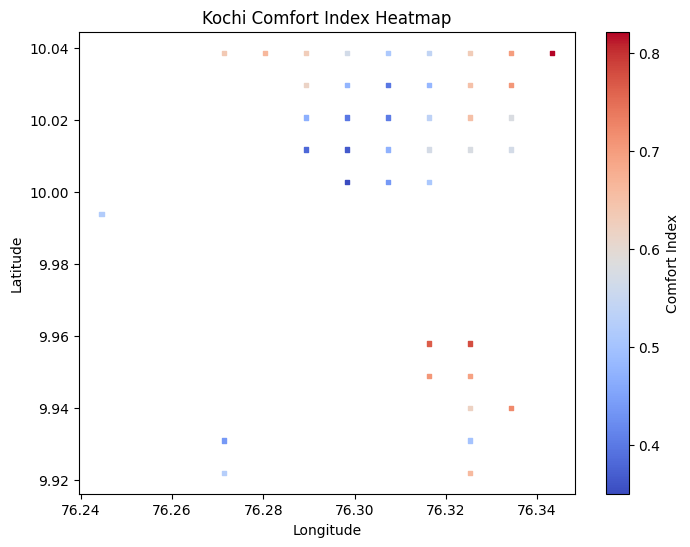

✅ Heatmap saved as Kochi_Comfort_Heatmap.png


In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df already exists with columns: x, y, comfort
# df = pd.read_csv("Comfort_Index_Kochi.csv")

plt.figure(figsize=(8, 6))
sc = plt.scatter(df["x"], df["y"], c=df["comfort"], cmap="coolwarm", s=10, marker="s")

plt.colorbar(sc, label="Comfort Index")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Kochi Comfort Index Heatmap")
plt.show()
#plt.savefig("Kochi_Comfort_Heatmap.png", dpi=300, bbox_inches="tight")
#plt.close()

print("✅ Heatmap saved as Kochi_Comfort_Heatmap.png")


In [30]:
pip install osmnx==1.9.1 networkx geopandas shapely folium


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: C:\Users\ASUS\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [31]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import folium
from shapely.geometry import Point


In [32]:
G = ox.graph_from_place("Kochi, Kerala, India", network_type='drive')


In [33]:
# Convert comfort data to GeoDataFrame
gdf_comfort = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:4326")

# Convert road network to GeoDataFrame
nodes, edges = ox.graph_to_gdfs(G)

# Spatial join: assign comfort score to nearest road segment
edges = gpd.sjoin_nearest(edges, gdf_comfort, distance_col='dist')

# Replace missing comfort values with average
edges['comfort'] = edges['comfort'].fillna(edges['comfort'].mean())

# Compute cost = 1 - comfort (less comfort = more cost)
edges['cost'] = 1 - edges['comfort']


C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [34]:
# Rebuild graph with comfort-based cost
G_comfort = ox.graph_from_gdfs(nodes, edges)


In [35]:
orig_point = (9.9822, 76.2753)   # Marine Drive
dest_point = (10.0183, 76.3612)  # Infopark Kochi

orig_node = ox.distance.nearest_nodes(G_comfort, orig_point[1], orig_point[0])
dest_node = ox.distance.nearest_nodes(G_comfort, dest_point[1], dest_point[0])


In [36]:
# Shortest path (by distance)
route_short = nx.shortest_path(G_comfort, orig_node, dest_node, weight='length')

# Most comfortable path (by comfort cost)
route_comfort = nx.shortest_path(G_comfort, orig_node, dest_node, weight='cost')


In [37]:
# Convert both routes to GeoDataFrames
gdf_short = ox.utils_graph.route_to_gdf(G_comfort, route_short)
gdf_comfort = ox.utils_graph.route_to_gdf(G_comfort, route_comfort)

# Create map
m = folium.Map(location=[9.97, 76.32], zoom_start=12)

# Add routes
folium.GeoJson(gdf_short, name="Shortest Route", style_function=lambda x: {'color': 'red', 'weight': 3}).add_to(m)
folium.GeoJson(gdf_comfort, name="Comfort Route", style_function=lambda x: {'color': 'green', 'weight': 3}).add_to(m)

folium.LayerControl().add_to(m)
m.save("Comfort_Routes_Kochi.html")
m
